In [1152]:
# 2 Neural network classification with PyTorch


## 1. Make classification data and get it ready

In [1153]:
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_sample = 1000
# Create circles
X, y = make_circles(n_samples=n_sample,
                    noise=0.03,
                    random_state=42)

In [1154]:
len(X), len(y)

(1000, 1000)

In [1155]:
print(X[:5])
print(y[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
[1 1 1 1 0]


In [1156]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                        "X2": X[:, 1],
                        "label": y})
circles.head(2)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1


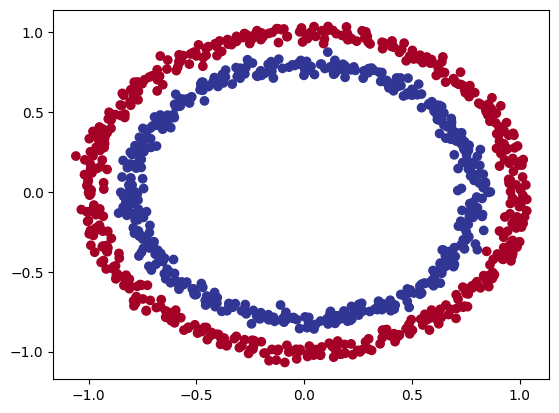

In [1157]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu)                 
#plt.scatter(circles['X1'], circles['X2'], c=circles['label'], cmap=plt.cm.RdYlBu)

**NOTE:** The data we're working with is often referred to as a toy dataset, a dataset
that is small enough to experiment but still sizeable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [1158]:
type(X), X.shape, type(y), y.shape

(numpy.ndarray, (1000, 2), numpy.ndarray, (1000,))

In [1159]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### 1.2 Turn data into tensors and create train and test splits

In [1160]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [1161]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% of data for test 80% for training 
                                                    random_state=42)

In [1162]:
len(X_train), len(X_test), len(y_train), len(y_test) 

(800, 200, 800, 200)

## 2. Building a model
Let's buil a model to classify our blue and red dots.

To do so, we want to:
1. Setup device agnostic code
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [1163]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [1164]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Let's create a model class that:
1. Subclasses `nn.Module` (almost all PyTorch models are subclasses of `nn.Module`).
2. Creates 2 `nn.Linear` layers in the constructor capable of handling the input and output shapes of `X` and `y`.
3. Defines a `forward()` method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target `device`. 

In [1165]:
X_train.shape

torch.Size([800, 2])

In [1166]:
# 1. Construct a model class that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features, produces 1 feature (y)

        # self.two_linear_layers = nn.Sequential(
        #     nn.Linear(in_features=2, out_features=5),
        #     nn.Linear(in_features=5, out_features=1)
        # )
    # 3. Define a forward method containing the forward pass computation
    def forward(self, x):
        # computation goes through layer_1 first then the output of layer_1 goes through layer_2
        return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)
model_0
            

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [1167]:
# Let's replocate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0, model_0.state_dict()

(Sequential(
   (0): Linear(in_features=2, out_features=5, bias=True)
   (1): Linear(in_features=5, out_features=1, bias=True)
 ),
 OrderedDict([('0.weight',
               tensor([[-0.0829, -0.2872],
                       [ 0.4691, -0.5582],
                       [-0.3260, -0.1997],
                       [-0.4252,  0.0667],
                       [-0.6984,  0.6386]], device='cuda:0')),
              ('0.bias',
               tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
              ('1.weight',
               tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
              ('1.bias', tensor([-0.1213], device='cuda:0'))]))

In [1168]:
# Make predictions with the model
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup loss function and optimizer

Which loss fucntion should we use? What about an optimizer?

Again.. this is problem specific.

For example for regression you might want MAE (mean absolute error) or MSE (mean squared error) and for classification you might want binary/categorical cross entropy loss.

As a reminder, loss function measures how wrong our predictions are.

And for the optimizers, two of the most common and useful are SGD and Adam, however PyTorch has many built-in options.

* For more common
* For the loss fucntion we are going to use `torch.nn.BCEWithLogitsLoss()` which combines a `sigmoid` activation function and binary cross entropy loss in one function.
* For different optimizers see `torch.optim`

In [1169]:
# Setup the loss fucntions

# BCELOSS = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
# loss_fn = nn.BCELoss() 
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [1170]:
# Calculate accuracy - out of 100 examples, with what precantage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

## 3. Train model

To Train a model, we need to:
1. Forward pass (make predictions)
2. Calculate the loss (compare predictions with ground truth)
3. Optimize the model (update the weights)
4. Loss backwards (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** inti **prediction probabilties** passing them to some kind of activation function 

(`sigmoid` function for binary classification, `softmax` function for multiclass classification).

Then we can convert our model's prediction probabilities into **prediction labels** by rounding them or using `argmax()`.

In [1171]:
# View the first 5 outputs of the forward pass on the test data 
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [1172]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [1173]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

In [1174]:
torch.round(y_pred_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')

For our prediction probability values, we need to perform range-style rounding on them:
* `y_pred_probs` >= 0.5, y=1 (class 1)
* `y_pred_probs` < 0.5, y=0 (class 0)

In [1175]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)
# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))
# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

## 3.2 Building training and testing loops


In [1176]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 100

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
    ### TRAINING ###
    model_0.train()

    # 1. Forwarrd pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    # loss = loss_fn(torch.sigmoid(y_logits), y_train) # BCELoss expects predicion probabilities as input
    loss = loss_fn(y_logits, ## BCEWithLogitsLoss() expects raw logits as input
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)
    
    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward (backpropagation)
    loss.backward()

    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### TESTING ###
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)
        
    # Print out what is happening
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.69796, Acc: 51.88% | Test Loss: 0.69440, Test Acc: 58.00%
Epoch: 10 | Loss: 0.69590, Acc: 51.25% | Test Loss: 0.69305, Test Acc: 53.00%
Epoch: 20 | Loss: 0.69490, Acc: 51.62% | Test Loss: 0.69254, Test Acc: 49.50%
Epoch: 30 | Loss: 0.69435, Acc: 51.12% | Test Loss: 0.69236, Test Acc: 49.50%
Epoch: 40 | Loss: 0.69401, Acc: 50.88% | Test Loss: 0.69232, Test Acc: 51.00%
Epoch: 50 | Loss: 0.69378, Acc: 50.25% | Test Loss: 0.69234, Test Acc: 50.00%
Epoch: 60 | Loss: 0.69362, Acc: 50.00% | Test Loss: 0.69239, Test Acc: 51.50%
Epoch: 70 | Loss: 0.69351, Acc: 50.25% | Test Loss: 0.69246, Test Acc: 51.00%
Epoch: 80 | Loss: 0.69342, Acc: 49.88% | Test Loss: 0.69254, Test Acc: 50.00%
Epoch: 90 | Loss: 0.69336, Acc: 49.88% | Test Loss: 0.69262, Test Acc: 53.00%


# 4. Make predictions and evaluate the model
From the metrics it looks like our model isn't learning anything. Let's try to improve it.

to do so, we're going to import function called `plot_decision_boundary()` https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [1177]:
import requests
from pathlib import Path

# Download helper fucntions from learn pytorch repo 
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download...")
else:
    print("Downloading helper_fucntions.py...")
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    r = requests.get(url)
    with open("helper_functions.py", "wb") as f:
        f.write(r.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download...


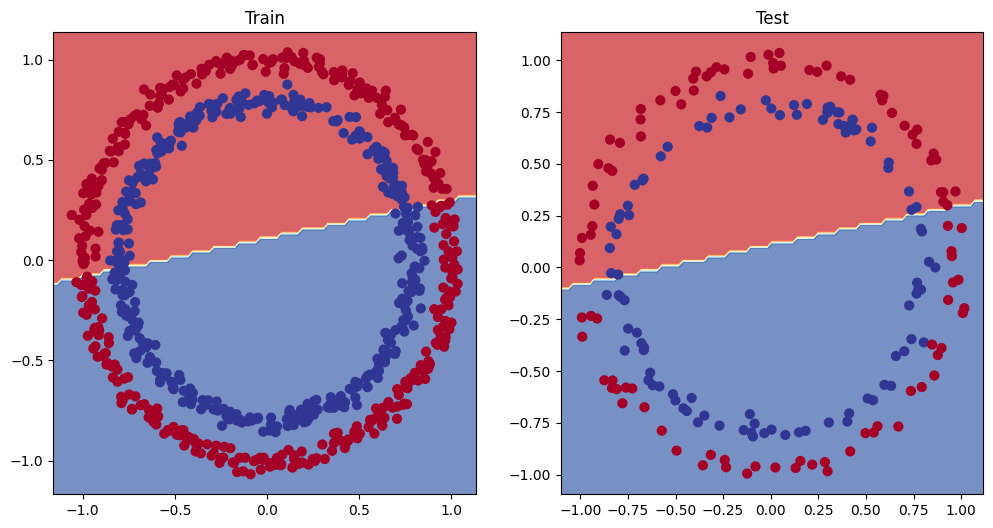

In [1178]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers = give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation function
* Change the learning rate
* Change the loss function

These options are all from a model's perspective because they deal directly with the mode, not the data.
> **Note:** *because you can adjust all of these by hand, they're referred to as **hyperparameters**. 
>
> And this is also where machine learning's half art half science comes in, there's no real way to know here what the best combination of values is for your project, best to follow the data scientist's motto of "experiment, experiment, experiment".


Let's try and imporve our model by:
* Adding more hidden units: 5 -> 10
* Increaase number of layers: 2->3
* Increase number of epochs: 100 -> 1000

In [1179]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # same as above but faster

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [1180]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=1e-1)

In [1181]:
# Write a training loop
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Put data on the target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### TRAINING ###
    model_1.train()
    # 1.Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                        y_pred=y_pred)
    # 3. Optimizer zero grad
    optimizer.zero_grad()
    # 4. Loss backward (backpropagation)
    loss.backward()
    # 5. Optimizer step (gradient descent)
    optimizer.step()

    ### TESTING ###
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Calculate test loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)
    # Print out what's happening every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")       


Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


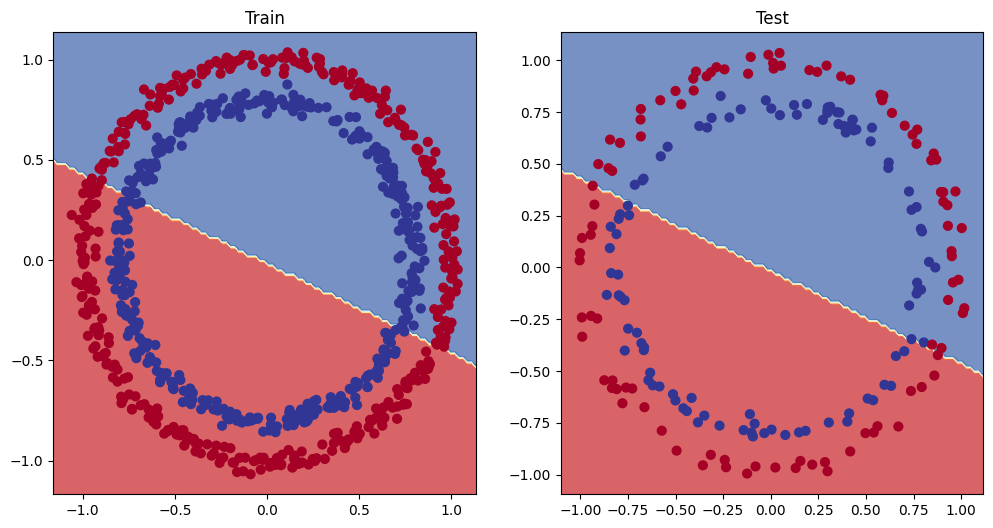

In [1182]:
# Plot the decision boundary
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 preparing data to see if our model canf it a straight line
 One way to troubleshoot a larger problem is to test out a smaller problem

In [1183]:
# Create some data
weight = 0.7
bias = 0.3

X_regression = torch.arange(0, 1, 0.01).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

X_regression[:5], y[:5]

(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([1., 1., 1., 1., 0.]))

In [1184]:
# Split data
train_split = int(len(X_regression) * 0.8)
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

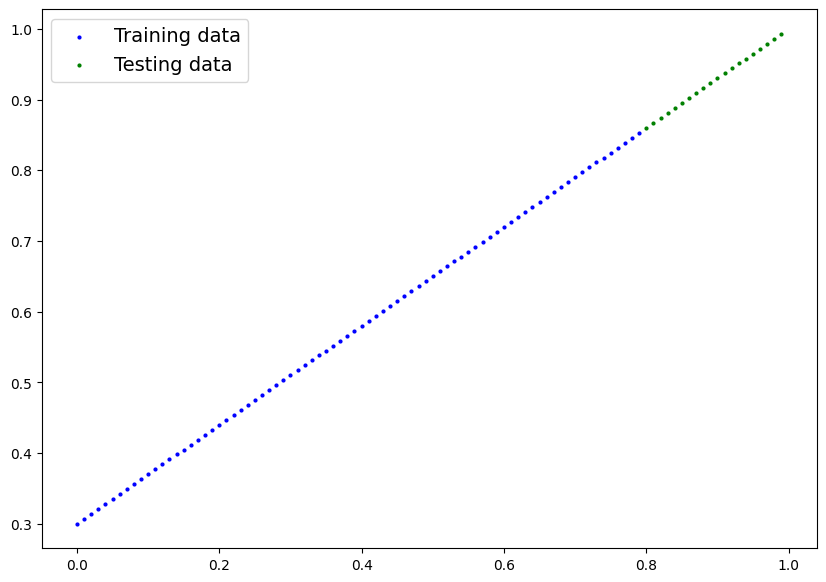

In [1185]:
plot_predictions(train_data=X_train_regression,
                train_labels=y_train_regression,
                test_data=X_test_regression,
                test_labels=y_test_regression)

In [1186]:
X_train_regression.shape, y_train_regression.shape

(torch.Size([80, 1]), torch.Size([80, 1]))

### 5.2 Adjust `model_1` to fit a straight line


In [1187]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(nn.Linear(in_features=1, out_features=10),
                        nn.Linear(in_features=10, out_features=10),
                        nn.Linear(in_features=10, out_features=1)).to(device)

In [1188]:
## Loss and optimzer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=1e-2)

In [1189]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

# Put data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### TRAINGING ###
    model_2.train()
    # 1. Forward pass
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### TESTING ###
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    # Print out stuff
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Loss: {loss:.5f} | Test loss: {test_loss:.5f}')

Epoch: 0 | Loss: 0.75986 | Test loss: 0.91103
Epoch: 100 | Loss: 0.02858 | Test loss: 0.00081
Epoch: 200 | Loss: 0.02533 | Test loss: 0.00209
Epoch: 300 | Loss: 0.02137 | Test loss: 0.00305
Epoch: 400 | Loss: 0.01964 | Test loss: 0.00341
Epoch: 500 | Loss: 0.01940 | Test loss: 0.00387
Epoch: 600 | Loss: 0.01903 | Test loss: 0.00379
Epoch: 700 | Loss: 0.01878 | Test loss: 0.00381
Epoch: 800 | Loss: 0.01840 | Test loss: 0.00329
Epoch: 900 | Loss: 0.01798 | Test loss: 0.00360


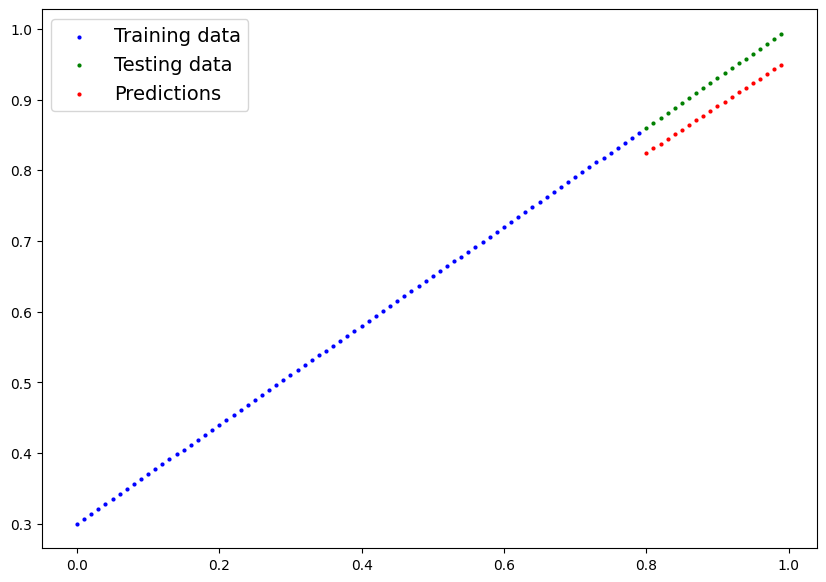

In [1190]:
model_2.eval()

with torch.inference_mode():
    y_preds = model_2(X_test_regression)
    
# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

## 6. The missing piece: non-linearity

### 6.1 Recreating non-linear data (red and blue circle)


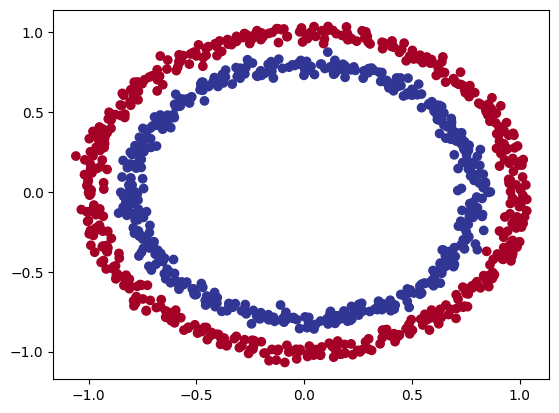

In [1191]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples=n_samples, shuffle=True, noise=0.03, random_state=42)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [1192]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split
# Turn data into tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## 6.2 Building a model with non-linearity

In [1193]:
from torch import nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # ReLU is non-linear activation function

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [1194]:
len(X_test), len(y_test)

(200, 200)

In [1195]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=1e-1)

torch.manual_seed(42)
torch.cuda.manual_seed(42)


X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 3000

for epoch in range(epochs):
    ### TRAINING ###
    model_3.train()
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    # 2. Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, 
                    y_pred=y_pred)
    # 3. Optimize a grad
    optimizer.zero_grad()
    # 4. Loss backwards
    loss.backward()
    # 5. Optimizer step
    optimizer.step()

    ### TESTING ###
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)
        
    # Print out what's happening
    if epoch % 250 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")    


Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 250 | Loss: 0.68894, Accuracy: 53.50% | Test Loss: 0.68840, Test Accuracy: 56.00%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 750 | Loss: 0.65988, Accuracy: 61.12% | Test Loss: 0.65604, Test Accuracy: 63.00%
Epoch: 1000 | Loss: 0.56818, Accuracy: 87.75% | Test Loss: 0.57378, Test Accuracy: 86.50%
Epoch: 1250 | Loss: 0.31076, Accuracy: 98.50% | Test Loss: 0.35566, Test Accuracy: 95.00%
Epoch: 1500 | Loss: 0.12188, Accuracy: 99.62% | Test Loss: 0.16512, Test Accuracy: 99.00%
Epoch: 1750 | Loss: 0.06372, Accuracy: 99.88% | Test Loss: 0.09429, Test Accuracy: 99.50%
Epoch: 2000 | Loss: 0.04176, Accuracy: 99.88% | Test Loss: 0.06583, Test Accuracy: 100.00%
Epoch: 2250 | Loss: 0.03029, Accuracy: 99.88% | Test Loss: 0.05230, Test Accuracy: 100.00%
Epoch: 2500 | Loss: 0.02383, Accuracy: 99.88% | Test Loss: 0.04363, Test Accuracy: 100.00%
Epoch: 2750 |

### 6.4 Evaluating a model trained with non-mlinear activation functions

In [1196]:
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]  

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

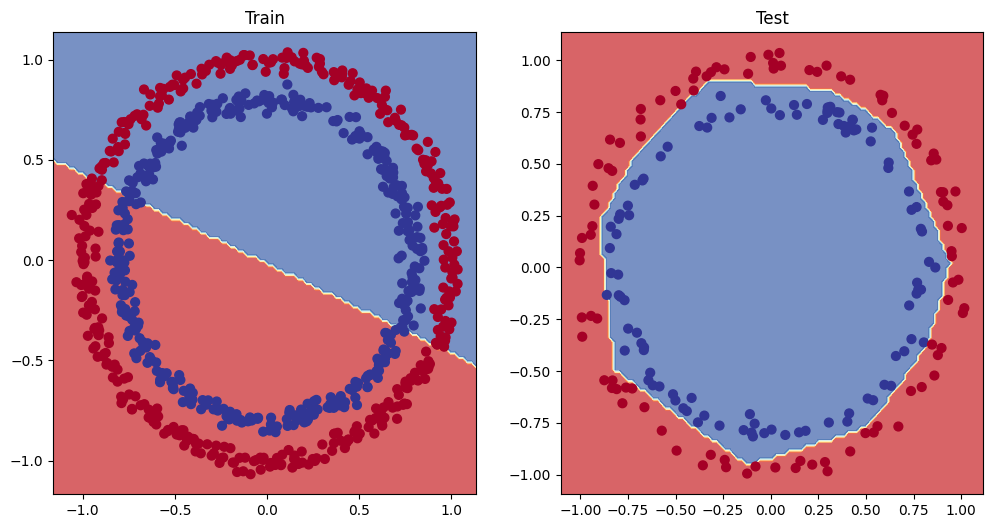

In [1197]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

## 7. Replicating non-linear activation functions
Neural networks, rather than us telling the model what to learn, we give it the tools to discover patterns in data and it tries to figure out the patterns on its own.

And these tools are linear & non-linear functions.
